[Link to video (part 1)](https://youtu.be/EDGtwudJnjM)

# This is transcribed from the following original source
http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/

#Compressed Sensing

In this post I’ll be investigating compressed sensing (also known as compressive sensing, compressive sampling, and sparse sampling) in Python. Since the idea of compressed sensing can be applied in wide array of subjects, I’ll be focusing mainly on how to apply it in one and two dimensions to things like sounds and images. Specifically, I will show how to take a highly incomplete data set of signal samples and reconstruct the underlying sound or image. It is a very powerful technique.

#$L^{1}\textrm{ vs. }L^{2}\textrm{ Fitting}$

As you might know, there are many different types of norms. Perhaps the most common and widely recognized one is the $L^{2}$ norm:

$\|\overrightarrow{x}\|_{2}=(\displaystyle\sum_{i=0}^{n}x^{2}_{i}) ^{1/2}$

The $L^{2}$ norm is nice because it is easily calculated, easily differentiated, and it has intuitive appeal (e.g., the norm of a vector is its length). A lot of very important algorithms and methods rely on the $L^{2}$, including least squares fitting.

That said, the $L^{2}$ norm isn’t the goto solution for everything. The other norms also have many interesting and useful properties. Consider the $L^{1}$ norm:

$\|\overrightarrow{x}\|_{1}=\displaystyle\sum_{i=0}^{n}|x_{i}|$

Instead of squaring each element, it simply takes its absolute value. Although the absolute value is annoying in the sense that it often introduces discontinuities in its derivatives, it does have some unique properties when compared to the squaring that takes place in the $L^{2}$ norm. Compressed sensing is all about exploiting these properties.

Let’s visualize some data with Python to see what I’m talking about.

<img src=https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%203%20-%20Goal%202%20-%20Turning%20Data%20into%20Images/Ex%204%20-%20compressed%20sensing/Data/imgs/compressed_sensing_slide_2.png width=400>


In [0]:
# make sure you've got the following packages installed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
from imageio import imread
import cvxpy as cvx

In [0]:
!git clone https://github.com/chokkan/liblbfgs
!sudo apt install libtool automake
!cd ./liblbfgs ; ./autogen.sh ; ./configure ; make ; make install

!git clone https://rtaylor@bitbucket.org/rtaylor/pylbfgs.git
!export CFLAGS="-I /usr/local/lib/python3.6/dist-packages/numpy/core/include $CFLAGS" ; cd pylbfgs ; python setup.py install

!rm 'Escher-Waterfall-1961.jpeg'
!wget "https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%203%20-%20Goal%202%20-%20Turning%20Data%20into%20Images/Ex%204%20-%20compressed%20sensing/Data/imgs/Escher-Waterfall-1961.jpeg"

Cloning into 'liblbfgs'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 485 (delta 7), reused 5 (delta 1), pack-reused 462
Receiving objects: 100% (485/485), 145.63 KiB | 768.00 KiB/s, done.
Resolving deltas: 100% (300/300), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  autoconf autotools-dev file libmagic-mgc libmagic1 libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext libtool-doc gcj-jdk
  m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev file libmagic-mgc libmagic1 libsigsegv2
  libtool m4
0 upgraded, 9 newly installed, 0 to remove and 4 not upgraded.
Need to ge

First what we’re going to do is create some arbitrary linear data including some noise. Let’s use the made-up equation:

$y=15x+3+ϵ$

where $ϵ$ is some normally distributed error with standard deviation $σ=0.1$.

In [0]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

Now let’s fit two lines to the data samples. For the first line, we’ll use the $L^{1}$ norm as the criterion for a good fit; for the second line, we’ll use the $L^{2}$ norm.

Optimization terminated successfully.
         Current function value: 1.077051
         Iterations: 55
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: 0.120124
         Iterations: 47
         Function evaluations: 92


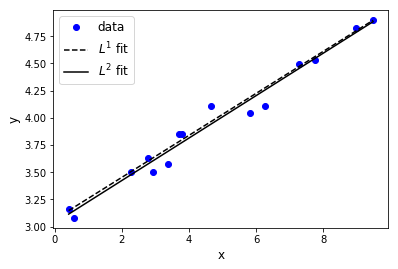

In [0]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

# plot results
fig, ax = plt.subplots()
ax.plot(x,y,'bo',label='data')
ax.plot(x,xopt1[0]*x+xopt1[1],'k--',label='$L^{1}$ fit')
ax.plot(x,xopt2[0]*x+xopt2[1],'k-',label='$L^{2}$ fit')
ax.set_xlabel('x',fontsize='large')
ax.set_ylabel('y',fontsize='large')
legend=ax.legend(fontsize='large')

Notice that both of the fits seem to do a pretty good job fitting the data. Sure, they don’t line up exactly, but they both are reasonable approximations given the noise.

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data, causing all kinds of headaches.

Optimization terminated successfully.
         Current function value: 9.375350
         Iterations: 72
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: 29.279529
         Iterations: 48
         Function evaluations: 94


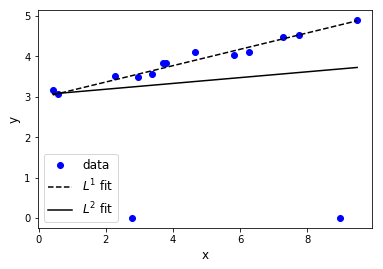

In [0]:
# adjust data by adding outlyers
y2 = y.copy()
#y2[3] += 4
#y2[13] -= 3
y2[3] = 0
y2[13] = 0

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))


# plot results
fig, ax = plt.subplots()
ax.plot(x,y2,'bo',label='data')
ax.plot(x,xopt12[0]*x+xopt12[1],'k--',label='$L^{1}$ fit')
ax.plot(x,xopt22[0]*x+xopt22[1],'k-',label='$L^{2}$ fit')
ax.set_xlabel('x',fontsize='large')
ax.set_ylabel('y',fontsize='large')
legend=ax.legend(fontsize='large')

When we re-plot the $L^{1}$ and $L^{2}$ fits we see something interesting: the $L^{1}$ fit remained true to the overall trend in the data, while the $L^{2}$ fit seemed to get “corrupted” by the outliers. Why does this happen? It comes down to the fact that $L^{2}$ error gets squared, while $L^{1}$ error does not. When you fit a line to data using an $L^{2}$ interpretation of error, the displacement of outliers has a disproportional impact because their already-big errors are get getting squared. Just look at the distance of the two outliers in our example and imagine squaring them – of course it’s not surprising that the $L^{2}$ line gets skewed!

However, when using an $L^{1}$ interpretation of error, the outliers contribute no more than their displacement. The result is a cleaner fit that more closely matches our intuition of what a good fit should look like. It’s this interesting property that opens the door to compressed sensing.

#Reconstruction of a Simple Signal
In this example (borrowed from Kutz<sup>[1](http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/#fn:1)</sup>), we will create an artificial sound wave, sample 10% of it, and reconstruct the original signal from the sample of 10%. This is one dimensional compressed sensing.

First, create a signal of two sinusoids.

Text(0, 0.5, 'y')

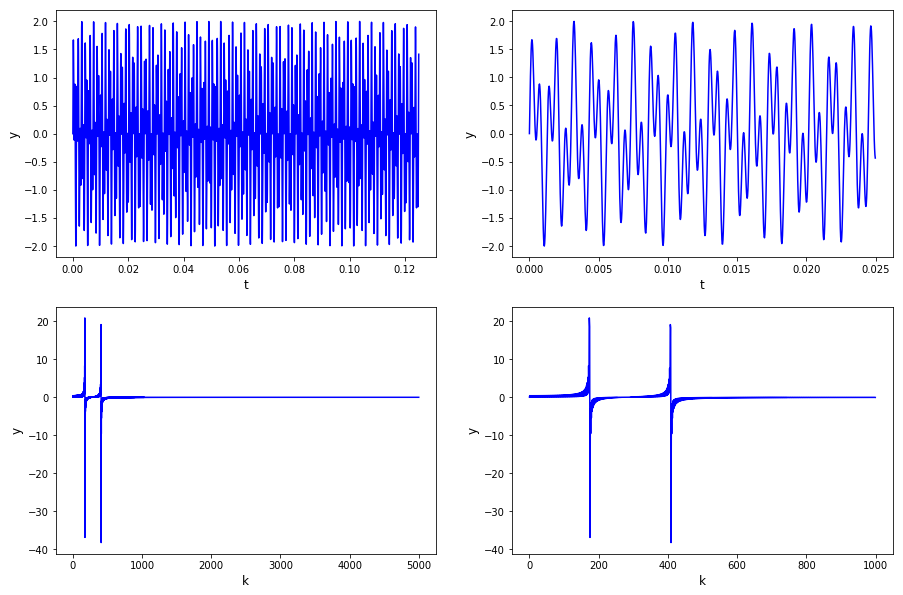

In [0]:
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')


# plot results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0,0].plot(t,y,'b',label='data')
axes[0,0].set_xlabel('t',fontsize='large')
axes[0,0].set_ylabel('y',fontsize='large')

axes[0,1].plot(t[:1000],y[:1000],'b',label='data')
axes[0,1].set_xlabel('t',fontsize='large')
axes[0,1].set_ylabel('y',fontsize='large')

axes[1,0].plot(yt,'b',label='$L^{2}$ fit')
axes[1,0].set_xlabel('k',fontsize='large')
axes[1,0].set_ylabel('y',fontsize='large')

axes[1,1].plot(yt[:1000],'b',label='$L^{2}$ fit')
axes[1,1].set_xlabel('k',fontsize='large')
axes[1,1].set_ylabel('y',fontsize='large')


In the plots above, we see that the signal has a clear pattern, yet is non-trivial. The plots in the top row are of the signal in the temporal domain at different scales. The plots in the bottom row are of the signal in the spectral domain (i.e., the signal’s frequency content). Considering the frequency domain in particular, we note that the spectrum is mostly zero except for the two spikes representing the two sine frequencies.

Now imagine sampling 10% of the temporal signal (see below). You’d have a data set that, to the naked eye, would look like nonsense. The underlying signal is would still be the same, as would be its frequency content (mostly zeros, with the exception of two spikes). One might ask if it is somehow possible to extract those two dominant frequencies from the incomplete data so that we might reconstruct the signal? The answer is yes!

Text(0, 0.5, 'y')

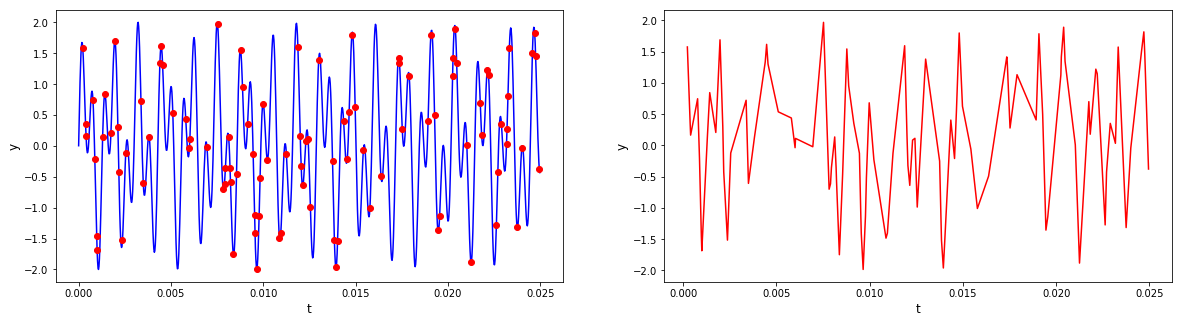

In [0]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]


# plot results
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
axes[0].plot(t[:1000],y[:1000],'b',label='data')
axes[0].plot(t2[t2<t[1000]],y2[t2<t[1000]],'ro',label='data')
axes[0].set_xlabel('t',fontsize='large')
axes[0].set_ylabel('y',fontsize='large')

axes[1].plot(t2[t2<t[1000]],y2[t2<t[1000]],'r',label='data')
axes[1].set_xlabel('t',fontsize='large')
axes[1].set_ylabel('y',fontsize='large')

Compressed sensing in this context is made possible by the fact that the signal’s frequency content is highly sparse. This is where the $L^{1}$ norm comes into play. What we want to do is, out of all possible signals, locate the simplest one that matches up with the known data. In other words, we want to use a minimization routine to find a set of frequencies satisfying two conditions: (a) the underlying signal matches up exactly (or as closely as possible) with that of our data; and (b) the $L^{1}$ norm of the frequencies is minimized. Such a routine will yield a sparse solution – exactly what we want.

In Python, there are a couple ways to accomplish this. Perhaps the easiest is to utilize the convex optimization library [CVXPY](http://www.cvxpy.org/en/latest/). Use the code below to minimize the norm of the signal’s frequencies with the constraint that candidate signals should match up exactly with our incomplete samples.

In [0]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 10000, constraints m = 10500
          nnz(P) + nnz(A) = 2519910
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -4.0000e+04   8.00e+00   1.02e+06   1.00e-01   3.39e+00s
 200   3.5693e+02   1.79e-02   3.49e-03   1.00e-01   6.82e+00s
 325   3.5735e+02   5.37e-03   1.70e-03   1.00e-01   8.

You might be asking: what the hell is that $A$ matrix? Well, it’s the key to the whole party. Let me explain.

In order to perform the minimization, we must somehow finagle our problem into a linear system of equations:

$Ax=b$

Specifically, we want to derive a matrix $A$ that can be multiplied with a solution candidate $x$ to yield $b$, a vector containing the data samples. In the context of our current problem, the candidate solution $x$ exists in the frequency domain, while the known data $b$ exists in the temporal domain. Clearly, the matrix $A$ performs both a sampling and a transformation from spectral to temporal domains.

Compressed sensing really comes down to being able to correctly derive the $A$ operator. Fortunately, there’s a methodology. Start off by letting $f$ be the target signal in vector form (if your signal is 2-dimensional or higher, flatten it) and $ϕ$ be the sampling matrix. Then:

$b=ϕf$

Now let $ψ$ be the matrix that transforms a signal from the spectral domain to the temporal domain. Given the solution $x$ in the frequency domain, it follows that:

$ψx=f$

Combining the two equations yields:

$Ax=b\textrm{ where }A≡ϕψ$

So, $A$ is simply made up of rows sampled from the domain transform matrix $ψ$. The $ψ$ matrix is easy to construct – it is the inverse discrete cosine transform acting upon the columns of the identity matrix. The matrix product $ψx$ is the equivalent to doing `idct(x)`.

Now that we’ve constructed the $A$ matrix and run the minimization, we can reconstruct the signal by transforming the solution out of the frequency domain and back into the temporal. Below, on the left, is the original signal and its frequency content. On the right is our $L^{1}$ approximation. I’d say that’s pretty good for only using 10% of the data!

Text(0, 0.5, 'y')

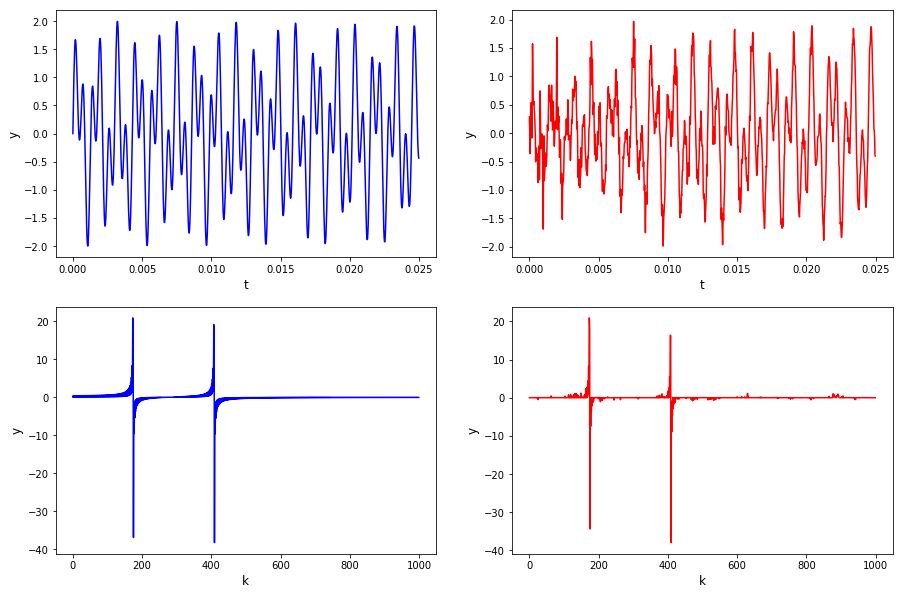

In [0]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)


# plot results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0,0].plot(t[:1000],y[:1000],'b',label='data')
axes[0,0].set_xlabel('t',fontsize='large')
axes[0,0].set_ylabel('y',fontsize='large')

axes[0,1].plot(t[:1000],sig[:1000],'r',label='data')
axes[0,1].set_xlabel('t',fontsize='large')
axes[0,1].set_ylabel('y',fontsize='large')

axes[1,0].plot(yt[:1000],'b',label='$L^{2}$ fit')
axes[1,0].set_xlabel('k',fontsize='large')
axes[1,0].set_ylabel('y',fontsize='large')

axes[1,1].plot(x[:1000],'r',label='$L^{2}$ fit')
axes[1,1].set_xlabel('k',fontsize='large')
axes[1,1].set_ylabel('y',fontsize='large')

One problem that stands out is that the quality of the reconstruction degrades noticeably at and around $t=0$. This is probably due to our sample interval violating the periodic boundary condition requirements of the cosine transform. Of course, given an arbitrary signal sample without any prior knowledge of its nature, it would be hard not to violate periodic boundary conditions. The good news is that now we have some very clear indications of the true signal’s frequencies. If desired, we could go back and resample the signal within an interval that satisfies periodic boundaries.

## Reconstruction of an Image (a 2D Signal)
Now let’s use what we learned from the 1-dimensional case to do compressed sensing in 2-dimensions. This is where the real fun begins because we can now try and reconstruct images.

Below, we will use exactly the same methodology as before to randomly sample and reconstruct the image Waterfall by M. C. Escher (approx. 1200 by 1600 pixels). Due to memory limitations imposed by the $A$ matrix, we’ll start off by considering a downsized version of the image (approx. 50 by 65 pixels). In the section that follows we’ll extend the routine to handle large images.

Note that SciPy doesn’t provide 2D versions of dct or idct. However, they can be easily constructed by recognizing that the 2D discrete cosine transform is nothing more than a `dct` acting upon the rows of $x$ followed by a second `dct` action upon its columns (or vice versa):

**`dct(dct(x.transpose()).transpose())≡dct(dct(x).transpose()).transpose()`**

As a personal preference, I like to tell SciPy’s `dct` and `idct` methods to act on the columns of a matrix (as opposed to the default behavior of acting on the rows). First of all, this keeps the Python code consistent with that of MATLAB. Second, it makes building matrix operators more intuitive (to me at least). For example, if we let $Y$ be an $m$ by $n$ matrix, with $I_{m}$ and $I_{n}$ being identity matrices of size $m$ and $n$ respectively, then

**`dct(Y, axis=0)≡dct(Im, axis=0)⋅Y    (MATLAB default)`**

whereas

**`dct(Y, axis=1)≡Y⋅dct(In, axis=1)    (SciPy default)`**

Either version can be made to work, but I feel like the first one is cleaner because it naturally keeps the matrix operator in front of the operand. Whenever I refer to the `dct` or `idct`, assume that I mean the `axis=0` variety.

rm: cannot remove 'Escher-Waterfall-1961.jpeg': No such file or directory
--2019-08-04 23:04:34--  http://cdn8.openculture.com/wp-content/uploads/2015/09/Escher-Waterfall-1961.jpeg
Resolving cdn8.openculture.com (cdn8.openculture.com)... 13.35.253.33, 13.35.253.2, 13.35.253.21, ...
Connecting to cdn8.openculture.com (cdn8.openculture.com)|13.35.253.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300667 (294K) [image/jpeg]
Saving to: ‘Escher-Waterfall-1961.jpeg’

Escher-Waterfall-19 100%[===================>] 293.62K  --.-KB/s    in 0.03s   

2019-08-04 23:04:35 (11.1 MB/s) - ‘Escher-Waterfall-1961.jpeg’ saved [300667/300667]



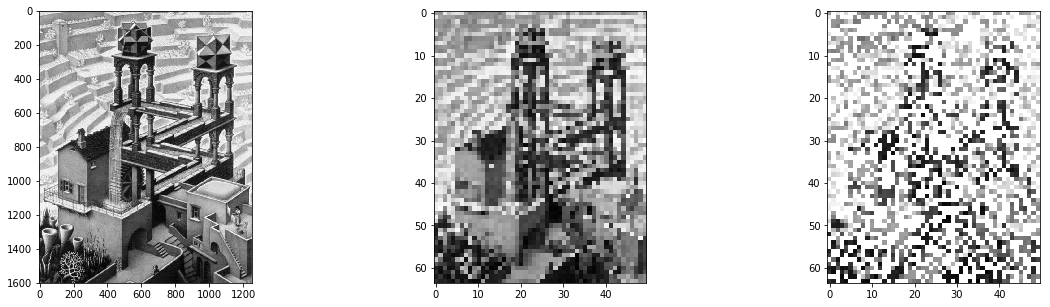

In [0]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig = imread('Escher-Waterfall-1961.jpeg', as_gray=True, pilmode='L') # read in grayscale
X = spimg.zoom(Xorig, 0.04)
ny,nx = X.shape

# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]

# put the pixel sample in an image
transformed=255*np.ones(X.shape)
transformed.T.flat[ri] = X.T.flat[ri]
#transformed=255*np.ones((X.shape[0]*X.shape[1],1))
#transformed[ri]=b;
#transformed=np.reshape(transformed,(X.shape[1],X.shape[0])).transpose()



# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].imshow(Xorig,cmap='gray')

axes[1].imshow(X,cmap='gray')

axes[2].imshow(transformed,cmap='gray')


As in the previous section, we’ll take a random sample of image indices, forming our $b$ matrix. Then, we’ll generate our $A$ matrix.

Creating the $A$ matrix for 2D image data takes a little more ingenuity than it did in the 1D case. In the derivation that follows, we’ll use the Kronecker product ⊗ and the fact that the 2D discrete cosine transform is *separable* to produce our operator $A$. 

Let $X$ be an image in the spectral domain and $D_{i}=idct(I_{i})$, where $I_{i}$ is the identity matrix of size $i$. Then:

$idct2(X)=idct(idct(X^{T})^{T})\\
=D_{m}(D_{n}X^{T})^{T}\\
=D_{m}XD^{T}_{n}$

If $vec(X)$ is the vector operator that stacks columns of $X$ on top of each other, then:

$vec(D_{m}XDTn)=(D_{n}⊗D_{m})vec(X)\\
=(D_{n}⊗D_{m})x\textrm{ where } x≡vec(X)$

Clearly, the Kronecker product is our desired transformation matrix $ψ$. Therefore, our matrix $A$ becomes $A=ϕ(D_{n}⊗D_{m})$, where $ϕ$ is the sampling matrix. You can calculate the Kronecker product in Numpy with `numpy.kron`. The main problem with this method is that the Kronecker product can become truly massive very quickly. If your target image is $m$ by $n$ and you’re taking $k$ samples, then the $A$ matrix has a size of $(mnk)^{2}$. That said, for small images it will be fine.

In [0]:
# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 6400, constraints m = 8000
          nnz(P) + nnz(A) = 5124480
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -2.5600e+04   2.52e+02   3.00e+08   1.00e-01   2.02e+01s
 200   9.2589e+04   7.30e-01   1.00e+00   1.00e-01   2.79e+01s
 400   9.1622e+04   1.77e-01   1.39e-02   1.00e-01   3.58

Reconstruct the signal and visualize!

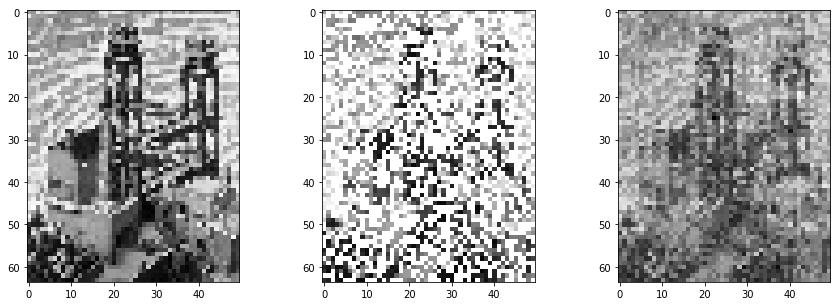

In [0]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

# create images of mask (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]



# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].imshow(X,cmap='gray')

axes[1].imshow(transformed,cmap='gray')

axes[2].imshow(Xa,cmap='gray')

Okay, the results aren’t fabulous. The original image on the far left is barely intelligible as it is. Resolution was low, so we had to take a large-ish sample of 50% (the boolean mask is shown middle left; the masked image is middle right). Regardless, it is clear the procedure worked: the reconstructed image on the far right definitely approximates the original, be it poorly.

## Optimization and Scalability
Considering our working proof-of-concept, there are a lot of ways it might be improved. The Kronecker-based method, although easy to implement, proves unusable for large images. What other methods are there?

Convex optimization using [CVXPY](http://www.cvxpy.org/en/latest/) isn’t necessarily the only way to find the $L^{1}$ minimum. A little bit of online research led me to the L-BFGS algorithm<sup>[6](http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/#fn:6)</sup> and its variant, the OWL-QN<sup>[3](http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/#fn:3)</sup>. The OWL-QN algorithm is of particular interest to us, as it allows one to fit a $L^{1}$ regularized model by minimizing a function of the form:

$f(x)=g(x)+C∥x∥_{1}$

where $f$ is a differentiable convex loss function and C is a constant. In our case, we might define $f$ to be the least squares objective function, which is simply the $L^{2}$ norm of the residual squared:

$f(x)=∥Ax−b∥^{2}_{2}$

The gradient of which is:

$∇f(x)=2(A^{T}Ax−A^{T}b)$

Now all that remains is to code it up! After trying several different options, I ended up settling on using [libLBFGS](http://www.chokkan.org/software/liblbfgs/) (written in C) for its OWL-QN implementation. To make it accessible from Python, I wrapped it using the C APIs for Python and Numpy. You can find my implementation at [PyLBFGS](https://bitbucket.org/rtaylor/pylbfgs). See the project README for installation instructions and basic use. Let me know if you encounter bugs.

The nice thing about [libLBFGS](http://www.chokkan.org/software/liblbfgs/) (and by extension [PyLBFGS](https://bitbucket.org/rtaylor/pylbfgs)) is that you can define the objective function anyway you like. In other words, we aren’t constrained to follow the $Ax=b$ model blindly. All that matters is the we are able to calculate the norm of the residual squared and its gradient. We need not generate $A$ at all!

The following code explains what I mean better than I could with words. Take special note of the evaluate callback passed to the OWL-QN algorithm.

In [0]:
from pylbfgs import owlqn

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

# fractions of the scaled image to randomly sample at
sample_sizes = (0.1, 0.01)

# read original image
#Xorig = spimg.imread('escher_waterfall.jpeg')
Xorig = imread('Escher-Waterfall-1961.jpeg')
ny,nx,nchan = Xorig.shape

# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

    # for each color channel
    for j in range(nchan):

        # extract channel
        X = Xorig[:,:,j].squeeze()

        # create images of mask (for visualization)
        Xm = 255 * np.ones(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:,j] = Xm

        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)

        # perform the L1 minimization in memory
        Xat2 = owlqn(nx*ny, evaluate, None, 5)

        # transform the output back into the spatial domain
        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        Z[i][:,:,j] = Xa.astype('uint8')
        
        

# plot results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axes[0,0].imshow(Xorig)

axes[0,1].imshow(masks[0])

axes[1,1].imshow(masks[1])

axes[0,2].imshow(Z[0])

axes[1,2].imshow(Z[1])


Iteration 1:
  fx = 4876899249.035967, xnorm = 1415.859034, gnorm = 139707.226207, step = 0.000007, k = 1, ls = 1

Iteration 2:
  fx = 1373219022.061467, xnorm = 48660.569961, gnorm = 64170.526906, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 340061371.690862, xnorm = 88697.749869, gnorm = 5082.247989, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 329161592.938899, xnorm = 87024.968946, gnorm = 3558.077349, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 315225891.798483, xnorm = 85763.689731, gnorm = 4315.990324, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 290617548.311466, xnorm = 87098.336118, gnorm = 4051.729669, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 282024711.128704, xnorm = 98333.472478, gnorm = 13248.114735, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 273279458.028650, xnorm = 85995.407778, gnorm = 7961.719065, step = 1.000000, k = 8, ls = 1

Iteration 9:
  fx = 250938341.549012, xnorm = 94962.107521, gnorm = 7579.168458, step = 0.2

Text(0.5, 1.0, 'reconstructed from 1%')

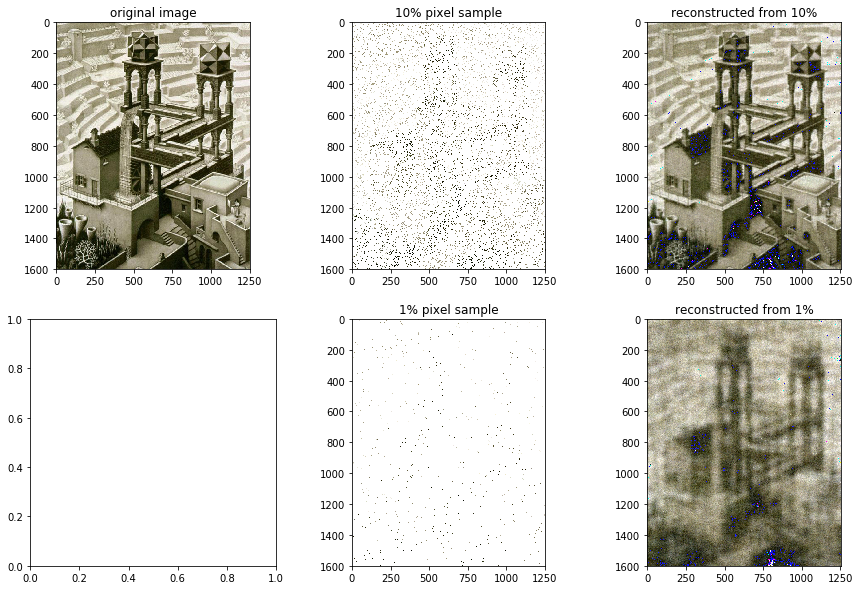

In [0]:
        

# plot results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axes[0,0].imshow(Xorig)
axes[0,0].set_title('original image')

axes[0,1].imshow(masks[0])
axes[0,1].set_title('10% pixel sample')

axes[1,1].imshow(masks[1])
axes[1,1].set_title('1% pixel sample')

axes[0,2].imshow(Z[0])
axes[0,2].set_title('reconstructed from 10%')

axes[1,2].imshow(Z[1])
axes[1,2].set_title('reconstructed from 1%')



The fast C implementation of OWL-QN allows us to process samples of the entire *Waterfall* image without any scaling required. And instead of doing everything in gray-scale like earlier, we can now afford to process each of the image’s three color channels. The solution shown above really demonstrates the power of compressed sensing. The original, full-color image is shown on the left. The middle image is the random 10% sample. The solution image is on the right. Although the solution contains some noticeable blemishes due to bad color channel mixing, the overall accuracy is uncanny. Furthermore, with a little extra care and attention, those blemishes might be removed – either via post-processing (e.g., a Gaussian filter) or via an improved compressed sensing implementation that takes into account color channels. One possibility is to try and determine the probable color palette beforehand and then incorporate it into the compressed sensing routine.

Just for kicks and giggles, I also included an image reconstructed from 1% of the available data. It’s definitely blurred, but nonetheless recognizable!

<img src=https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%203%20-%20Goal%202%20-%20Turning%20Data%20into%20Images/Ex%204%20-%20compressed%20sensing/Data/imgs/output_26_1.png width=600>

<img src=https://raw.githubusercontent.com/jojker/PML_Workshops/master/Summer%202019/Day%203%20-%20Goal%202%20-%20Turning%20Data%20into%20Images/Ex%204%20-%20compressed%20sensing/Data/imgs/output_28_1.png width=600>

Kutz, J. N. “Data-driven modeling and scientific computing: Methods for Integrating Dynamics of Complex Sys-tems and Big Data.” (2013). ↩

Candè, Emmanuel J., and Michael B. Wakin. “An introduction to compressive sampling.” Signal Processing Magazine, IEEE 25.2 (2008): 21-30. ↩

Andrew, Galen, and Jianfeng Gao. “Scalable training of L1-regularized log-linear models.” Proceedings of the 24th international conference on Machine learning. ACM, 2007. ↩

Wikipedia contributors. “Compressed sensing.” Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 26 Mar. 2016. Web. 26 May. 2016. ↩

Wikipedia contributors. “Kronecker product.” Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 19 May. 2016. Web. 26 May. 2016. ↩

Wikipedia contributors. “Limited-memory BFGS.” Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 16 May. 2016. Web. 26 May. 2016. ↩